> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

# 05 - Semi-supervised Anomaly Detection Using Convolutional Autoencoder

Authored by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai

## Notebook Description
This tutorial will walk you through on how to perform anomaly detection using convolutional autoencoder and how to interpret it. All the techniques is readily available in Scikit-learn library. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Prepare dataset to be feed into deep learning model
2. Build and apply convolutional autoencoder model 
3. Perform unsupervised anomaly detection tasks on time series data

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)
3. [Model Development](#model-dev) 
4. [Evaluation](#evaluation)
5. [Exercise](#exercise)
6. [Reference](#reference)
7. [Bonus](#bonus)



## <a name="configuration">Notebook configurations</a>
Following are the libraries that needs to be imported and used for this tutorial.

In [1]:
# Importing libraries
import sys
from datetime import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# seed configuration
np.random.seed(38)
torch.manual_seed(38)

## <a name="dataset">Dataset</a>
The dataset will be generated using NumPy and Pandas library. Two datasets will be generated, with both constituting normal data and also anomalous data that differs from normal data. For the first dataset (hereinafter known as training set), normal data are generated as being in the normal distribution of mean 3 and standard deviation of 1, while anomalous data are generated in the uniform distribution ranging from 10 to 20. For the second dataset (hereinafter known as test set), normal data are generated as being in the normal distribution of mean 3 and standard deviation of 1, while anomalous data are generated in the uniform distribution ranging from 20 to 25.

In [2]:
"""Generate training data"""
# instantiate datetime object and datetimeindex for Pandas DataFrame
start_time = datetime(2021, 1, 1, 0, 0, 0)
end_time = datetime(2021, 1, 14, 0, 0, 0)
datetime_index = pd.date_range(start=start_time, end=end_time, freq="H")

# generate 280 samples of normal data that has normal distribution of mean 3 and standard deviation of 1
normal_data = 3 + np.random.randn(280, 1)

# generate 33 samples of anomaly data that has uniform distribution in the range of 10 to 20
anomaly_data = np.random.uniform(low=10, high=20, size=(33, 1))

# concantenate normal data and anomaly data along first axis
data = np.r_[normal_data, anomaly_data]

# construct a Pandas DataFrame using generated data
df_train = pd.DataFrame(data=data, index=datetime_index, columns=['value'])

# preparing ground truth for evaluation
df_train['anomaly_label'] = np.where(df_train['value'] > 10, 1, 0)

In [3]:
"""Generate test data"""
# instantiate datetime object and datetimeindex for Pandas DataFrame
start_time = datetime(2021, 1, 15, 0, 0, 0)
end_time = datetime(2021, 1, 28, 0, 0, 0)
datetime_index = pd.date_range(start=start_time, end=end_time, freq="H")

# generate 280 samples of normal data that has normal distribution of mean 3 and standard deviation of 1
normal_data = 3 + np.random.randn(280, 1)

# generate 33 samples of anomaly data that has uniform distribution in the range of 15 to 25
anomaly_data = np.random.uniform(low=15, high=25, size=(33, 1))

# concantenate normal data and anomaly data along first axis
data = np.r_[normal_data, anomaly_data]

# construct a Pandas DataFrame using generated data
df_test = pd.DataFrame(data=data, index=datetime_index, columns=['value'])

# preparing ground truth for evaluation
df_test['anomaly_label'] = np.where(df_test['value'] > 20, 1, 0)

## <a name="analytics">Basic Analytics</a>
Let's do some basic analytics and see what nugget can we find out of the training dataset! We will first compute the descriptive statistics for the data.

**Note: Since we are not supposed to know any information about the test dataset, we will not perform any analytics on it.**

In [4]:
df_train.value.describe()

count    313.000000
mean       4.386052
std        3.873258
min        0.422327
25%        2.489656
50%        3.246259
75%        4.166395
max       19.824927
Name: value, dtype: float64

We can see from the statistics above that the mean for the data is 4.39, while standard deviation is 3.87. It deviates quite significantly from what we intended it to be for the normal data. Let us also compute the number of anomaly data that are in the data (which were generated by us earlier).

In [5]:
anomaly_class_counts = df_train.anomaly_label.value_counts()
total_samples = len(df_train)

print(anomaly_class_counts)
print(f"\n\nTotal number of samples is: {total_samples}")
print(f"\n\nRatio of anomaly data to normal data is: {df_train.anomaly_label.value_counts()[1]/df_train.anomaly_label.value_counts()[0]:.2f}")

0    280
1     33
Name: anomaly_label, dtype: int64


Total number of samples is: 313


Ratio of anomaly data to normal data is: 0.12


We can see that there are a total of 33 anomaly data out of 313 samples of data. That constitutes 12% of the entire dataset. Could it be that the presence of anomaly data skewed the distribution of the data? Let's compute the descriptive statistics of normal data only using boolean indexing on Pandas DataFrame.

In [6]:
df_train[df_train["anomaly_label"]==0].describe()

,value,anomaly_label
count,280.000000,280.0
mean,3.141839,0.0
std,1.062202,0.0
min,0.422327,0.0
25%,2.434580,0.0
50%,3.141056,0.0
75%,3.744570,0.0
max,6.074830,0.0


Indeed, we can see that the mean and standard deviation of normal data are 3.14 and 1.06 respectively, fairly close to our expected values of 3 and 1. Do note that there will be slight discrepancies of the actual statistics as this is a randomly generated data with a finite size. Now, we will plot a scatter plot to visualize the data distribution.

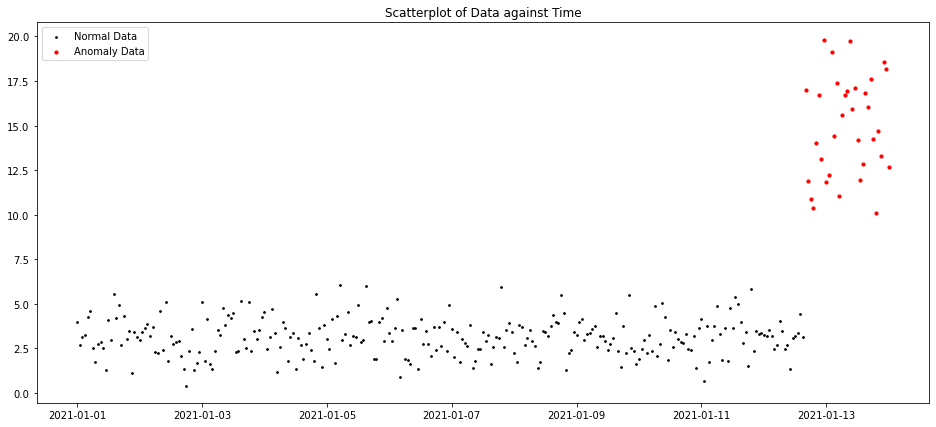

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 7)
plt.title("Scatterplot of Data against Time")
plt.scatter(x=df_train.index, y=df_train['value'], color='k', s=3., label='Normal Data')
plt.scatter(x=df_train.index[df_train['anomaly_label']==1], y=df_train['value'][df_train['anomaly_label']==1], color='r', s=10, label='Anomaly Data')
plt.legend()
plt.show();

## <a name="model-dev">Model Development</a>
After performing some basic analytics on the dataset at hand, we will start to build a model to detect anomalies in the dataset. However, we need to do some pre-processing first before building the model. We will first separete out the feature first, and then reshape it into a 2D array.

In [8]:
# extract the features and reshape to 2D array
x_train = df_train.value.to_numpy().reshape(-1, 1)
x_test = df_test.value.to_numpy().reshape(-1, 1)

# filtering normal data only for model development and reshape to 2D array
x_train_normal = df_train.value[df_train.anomaly_label == 0].to_numpy().reshape(-1, 1)

# split data for validation
x_train_normal, x_valid_normal = train_test_split(x_train_normal, test_size=0.2, random_state=38, shuffle=False)

It is vital to prepare our data into a form that is ingestible by our model, and for convolutional model it will usually be transformed into the shape of ``(N, C, L)``, where N denotes batch size, C denotes number of channels, and L denotes length of signal sequence. The transformation process is done alongside the transformation of NumPy ``ndarray`` into Torch ``FloatTensor``. A customized class inheriting from PyTorch's ``Dataset`` class is written to return a ``Dataset`` instance.

In [9]:
class PytorchDataset(Dataset):
    """
    Customized class inheriting from Dataset class of PyTorch module.
    Initialize argument to torch.FloatTensor and unrolling it to shape (N, C, L) where N = batch size, C = number of channels and L = length of signal sequence.
    Return length of class and particular sample when indexing.
    """
    def __init__(self, x: np.ndarray, size: int, step: int = 1):
        self.sequences = torch.FloatTensor(x).unfold(0, size, step)

    
    def __len__(self):
        return self.sequences.size(0)
    
    def __getitem__(self, index):
        x = self.sequences[index]
        return x
    
# instantiate a tensor using the custom class
train_tensor = PytorchDataset(x_train_normal, 10)
valid_tensor = PytorchDataset(x_valid_normal, 10)
test_tensor = PytorchDataset(x_test, 10)


print(f"The first sample in the train_tensor instance is: \n{train_tensor[0]}")
print(f"\n\nThe shape of one sample is: {train_tensor[0].shape}")

The first sample in the train_tensor instance is: 
tensor([[4.0087, 2.6769, 3.1277, 3.2798, 4.2887, 4.6253, 2.5308, 1.7506, 2.7396,
         2.8524]])


The shape of one sample is: torch.Size([1, 10])


We see that we have successfully transformed the ``ndarray`` into ``FloatTensor`` with one channel and sequence of length 10. Let's continue and convert it to a ``DataLoader`` then for batch training purpose.

In [10]:
# feeding Dataset into DataLoader for batching during model training
batch_size = 32
train_loader = DataLoader(dataset=train_tensor,
                            batch_size=batch_size,
                            shuffle=False)
valid_loader = DataLoader(dataset=valid_tensor,
                            batch_size=batch_size,
                            shuffle=False)

dataloaders = {'train': train_loader, 'valid': valid_loader}

In [11]:
# sanity check for one batch of data
len(next(iter(train_loader)))

32

The ``train_loader`` does return 32 samples of data when one batch of data is loaded. Now, we are ready to build our deep learning model! We will be using a convolutional autoencoder for the purpose of anomaly detection. Model architecture of a convolutional autoencoder can be defined as follow.

In [12]:
# define model architecture
class ConvAutoencoder(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        self.conv1d1 = nn.Conv1d(in_channels, 32, 5, stride=2, padding=3)
        self.dropout1 = nn.Dropout(p=0.2, inplace=True)
        self.conv1d2 = nn.Conv1d(32, 16, 5, stride=2, padding=3)
        ## bottleneck ##
        self.convtranspose1d1 = nn.ConvTranspose1d(16, 16, 5, stride=2, padding=3)
        self.dropout2 = nn.Dropout(p=0.2, inplace=True)
        ## decoder layer ##
        self.convtranspose1d2 = nn.ConvTranspose1d(16, 32, 5, stride=2, padding=3)
        self.convtranspose1d3 = nn.ConvTranspose1d(32, out_channels, 4, stride=2, padding=3)
        
    def forward(self, x):
        x = F.relu(self.conv1d1(x))
        x = F.relu(self.conv1d2(x))
        x = F.relu(self.convtranspose1d1(x))
        x = F.relu(self.convtranspose1d2(x))
        x = self.convtranspose1d3(x)
                
        return x

# instantiate the model
model = ConvAutoencoder(in_channels=1, out_channels=1)
print(model)

ConvAutoencoder(
  (conv1d1): Conv1d(1, 32, kernel_size=(5,), stride=(2,), padding=(3,))
  (dropout1): Dropout(p=0.2, inplace=True)
  (conv1d2): Conv1d(32, 16, kernel_size=(5,), stride=(2,), padding=(3,))
  (convtranspose1d1): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(2,), padding=(3,))
  (dropout2): Dropout(p=0.2, inplace=True)
  (convtranspose1d2): ConvTranspose1d(16, 32, kernel_size=(5,), stride=(2,), padding=(3,))
  (convtranspose1d3): ConvTranspose1d(32, 1, kernel_size=(4,), stride=(2,), padding=(3,))
)


After configuring the model, we need to configure certain hyperparameters that are required for model training.

In [13]:
epochs = 50
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Then, we will write a training loop to implement model training and validation at each epoch.

In [14]:
loss_score = {'train': [], 'valid': []}
for epoch in range(epochs):
    # uncomment to view number of epoch during training/validation
#     print(f'Epoch {epoch+1}/{epochs}')
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        loss_cumsum = 0.0
        total_iterations = 0.0

        # Loop over batches of data
        for idx, x in enumerate(dataloaders[phase]):

            with torch.set_grad_enabled(phase == 'train'):
                out = model(x)
                loss = criterion(out, x)

                # if the current phase is training phase, then do backward propagation
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            loss_cumsum += loss.item() * out.size(0)
            total_iterations += out.size(0)

        epoch_loss = loss_cumsum / total_iterations
        # uncomment to view loss score by epoch
#         print(f'{phase.upper()} Loss: {epoch_loss}')
        loss_score[phase].append(epoch_loss)

Loss scores can then be plotted to check whether the model has converged.

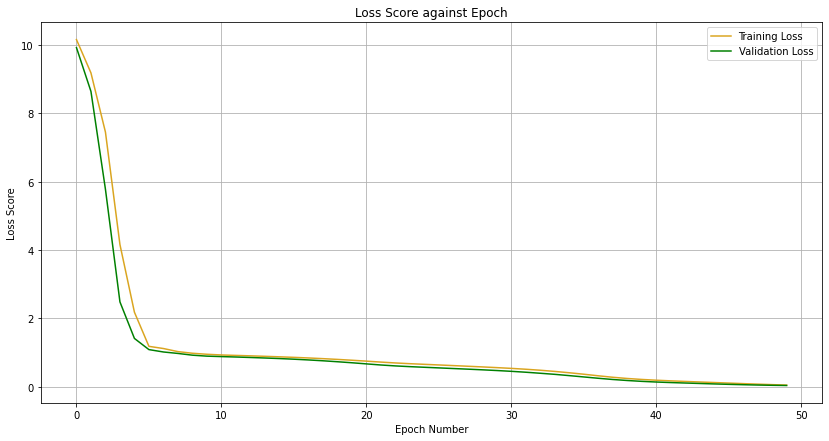

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
ax.set_title("Loss Score against Epoch")
ax.grid(b=True)
ax.set_xlabel("Epoch Number")
ax.set_ylabel("Loss Score")
ax.plot(loss_score['train'], color='goldenrod', label='Training Loss')
ax.plot(loss_score['valid'], color='green', label='Validation Loss')
ax.legend();

## <a name="evaluation">Evaluation</a>
Our model is ready to be evaluated! We will be evaluating our model against all three datasets on hand, which are training set, validation set and test set. Since this is a semi-supervised task where we only train our model using normal data, we have to set a threshold to determine whether the data is considered as normal or anomalous data. Recall that the working principle of an autoencoder is to reconstruct the data from input. So if the output of a trained autoencoder differs significantly from the input, we consider the input data as an anomaly as the autoencoder model was not able to recreate it in a similar fashion. The threshold is the important hyperparameter to determine whether the reconstruction loss is high enough for us to consider the input data as an anomaly. To summarize the usage of threshold:

* if reconstruction loss > threshold: input data is anomaly
* else if reconstruction loss < threshold: input data is normal

We are now going to demonstrate on how we can determine the threshold using MSE.

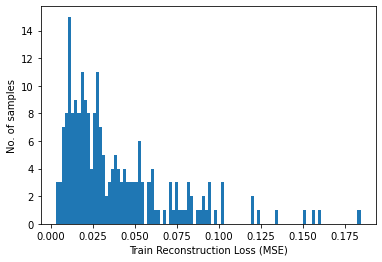

The threshold selected for train reconstruction loss is: 0.18416845798492432


In [16]:
model.eval()
train_reconstruction_loss = []
for idx, x in enumerate(DataLoader(train_tensor, batch_size=1, shuffle=False)):
    with torch.no_grad():
        output = model(x)
        reconstruction_loss = criterion(x, output)
        train_reconstruction_loss.append(reconstruction_loss.item())


plt.hist(train_reconstruction_loss, bins=100)
plt.xlabel("Train Reconstruction Loss (MSE)")
plt.ylabel("No. of samples")
plt.show()

threshold = np.max(train_reconstruction_loss)
print(f"The threshold selected for train reconstruction loss is: {threshold}")

We can see that most of the training sample's reconstruction loss is grouped around 0.000 to 0.075. We will choose the largest reconstruction loss and set it as the threshold. It is then just a simple of filtering any input data that when reconstructed by the model, has reconstruction loss more than the threshold. We will be using the entire training dataset (which includes anomalous data) to inspect the performance of our model.

In [17]:
model.eval()
train_reconstruction_loss = []
for idx, x in enumerate(DataLoader(PytorchDataset(x_train, 10), batch_size=1, shuffle=False)):
    with torch.no_grad():
        output = model(x)
        reconstruction_loss = criterion(x, output)
        train_reconstruction_loss.append(reconstruction_loss.item())

# return boolean array indicating whether the sequence is an anomaly (True) or not (False)
anomalies = train_reconstruction_loss > threshold
print(f"Total of anomaly sequence: {np.sum(anomalies)}")
print(f"\n\nIndices of anomaly sequence: {np.where(anomalies)}")

Total of anomaly sequence: 33


Indices of anomaly sequence: (array([271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
       284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
       297, 298, 299, 300, 301, 302, 303], dtype=int64),)


We see that using the threshold set, we can find certain data that result in reconstruction loss larger than the threshold. The code above actually return a list of indices of such data. 

Since we know the indices of anomalous data, we can also identify the corresponding timestamps from the DataFrame. Below is a simple description of how this is achieved.

In our case, we are using a sequence length of 10 for each sample of data that is fed into our model. It might help you if you imagine it as a window, whereby for each window there are 10 consecutive values that are fed into the model for it to reconstruct a new window (or sequence) of 10 consecutive values. We have actually prepared our data in the following manner (values shown is the index of data in the DataFrame, instead of the values): 

* 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
* 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
* 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
* 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
* ...

Other than the initial and the final (window_size - 1) data values, all other data will appear in more than one of the sequences of data. Since we are trying to reconstruct a sequence of data, even if a sequence is identified as containing anomalous data, how can we know whether which data in the sequence is an anomaly? 

A simple way to solve this is to check for which of these data occurred in sequences that are all marked as anomalous. In our example above, if the first 3 sequences are marked as anomaly, we will mark all the data that corresponds to the indices which are present in all the three anomalous sequences above (which are ``1, 2, 3, 4, 5, 6, 7, 8, 9, 10``) as anomaly while data that corresponds to the indices that only present in certain sequences as normal data (which are ``0, 12, 13``).

We are going to implement this logic in the following code.



Number of detected anomalies are: 24


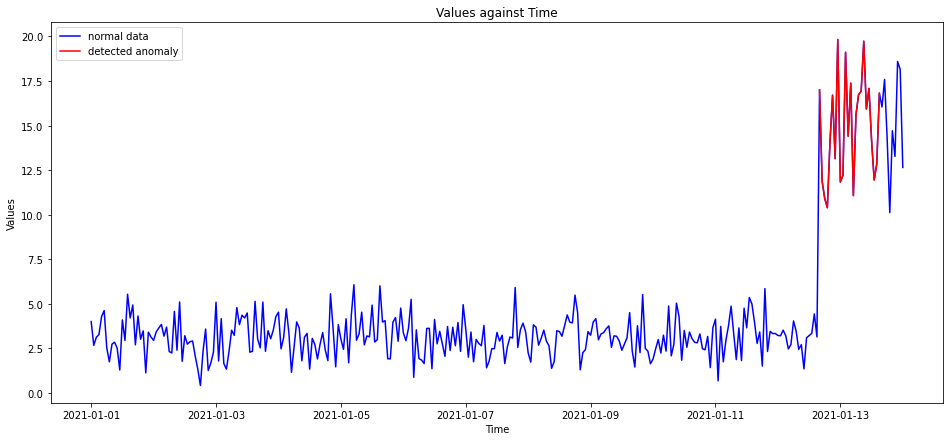

In [18]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []

# window here corresponds to the sequence length of data feed into the model, which is 10 in this case
sequence_length = 10

# this code specifies that the first value to be counted start from 9, which is the 10th value so that the body of for-loop can loop over the previous number without negative indexing
# this code also specifies the condition to stop at len(data) - window + 1, which is the last available data which we can input into the model as we need at least sequence length of 10 for inference
for data_idx in range(sequence_length - 1, len(x_train) - sequence_length + 1):
    # return the index of data if the data is considered as an anomaly in multiple inferences
    if np.all(anomalies[data_idx - sequence_length + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
        
# overlaying anomalies on original test data plot
df_detected_anomalies = df_train.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
fig.set_size_inches(16, 7)
# ax.scatter(x=df_train.index, y=df_train.value, c='b', s=3., label='normal data')
# ax.scatter(x=df_detected_anomalies.index, y=df_detected_anomalies.value, c='r', s=16., label='detected anomaly')
ax.plot(df_train.value, c='b', label='normal data')
ax.plot(df_detected_anomalies.value, c='r', label='detected anomaly')
ax.set_xlabel("Time")
ax.set_ylabel("Values")
ax.set_title("Values against Time")
ax.legend()
print(f"\n\nNumber of detected anomalies are: {len(df_detected_anomalies)}")

Based on the visualization, we can see that our model can accurately detect anomalies in our training data. Note that there are a number of anomalies at the end which are not detected as anomaly, this is simply because they are not fed into the data as there are not enough data to be grouped into a sample with sequence length of 10 into the model. Now, by using the same logic, we will test our model against the prepared test dataset.

The threshold selected for test reconstruction loss is: 0.18416845798492432


Total of anomaly sequence: 41


Indices of anomaly sequence: (array([ 28,  81,  85, 200, 203, 204, 205, 260, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
       289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
       302, 303], dtype=int64),)


Number of detected anomalies are: 24


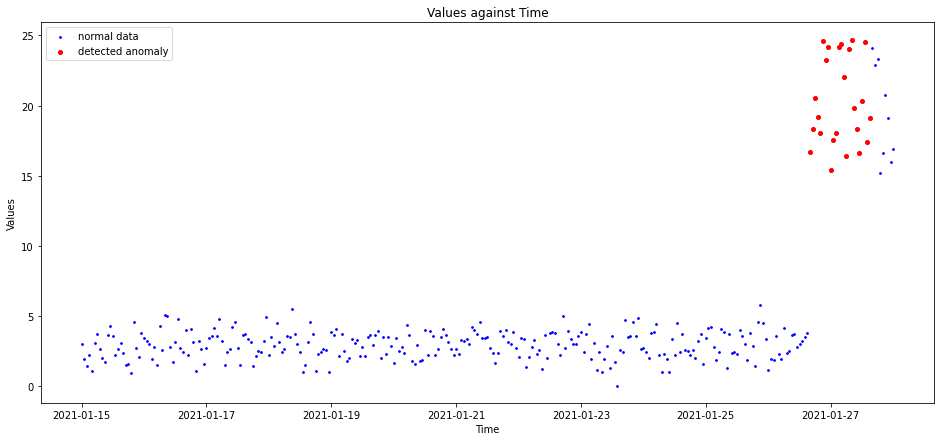

In [19]:
model.eval()
test_reconstruction_loss = []
for idx, x in enumerate(DataLoader(test_tensor, batch_size=1, shuffle=False)):
    with torch.no_grad():
        output = model(x)
        reconstruction_loss = criterion(x, output)
        test_reconstruction_loss.append(reconstruction_loss.item())

print(f"The threshold selected for test reconstruction loss is: {threshold}")        

test_anomalies = test_reconstruction_loss > threshold
print(f"\n\nTotal of anomaly sequence: {np.sum(test_anomalies)}")
print(f"\n\nIndices of anomaly sequence: {np.where(test_anomalies)}")

test_anomalous_data_indices = []
sequence_length = 10

for data_idx in range(sequence_length - 1, len(x_test) - sequence_length + 1):
    if np.all(test_anomalies[data_idx - sequence_length + 1 : data_idx]):
        test_anomalous_data_indices.append(data_idx)
        
df_test_detected_anomalies = df_test.iloc[test_anomalous_data_indices]
fig, ax = plt.subplots()
fig.set_size_inches(16, 7)
ax.scatter(x=df_test.index, y=df_test.value, c='b', s=3., label='normal data')
ax.scatter(x=df_test_detected_anomalies.index, y=df_test_detected_anomalies.value, c='r', s=16., label='detected anomaly')
# ax.plot(df_test.value, c='b', label='normal data')
# ax.plot(df_test_detected_anomalies.value, c='r', label='detected anomaly')
ax.set_xlabel("Time")
ax.set_ylabel("Values")
ax.set_title("Values against Time")
ax.legend()
print(f"\n\nNumber of detected anomalies are: {len(df_test_detected_anomalies)}")

From the visualization, we can see that our model performs fairly well for when tested. 

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
**INSTRUCTIONS**: You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules that you need has already been imported at this point.

In [20]:
# import modules
### BEGIN SOLUTION

### END SOLUTION

### Dataset
**INSTRUCTIONS:** We will be using an artificial data, which is provided in the *Numenta Anomaly Benchmark* (NAB) repo. Load the data into a DataFrame using URL provided. Note that the training data only contains normal data as this is a semi-supervised task. The test data consists of both normal and anomalous data.

In [21]:
# this is one way of loading data on the fly, just by specifying the URL
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
train_data_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
train_data_url = master_url_root + train_data_url_suffix
test_data_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
test_data_url = master_url_root + test_data_url_suffix

# load data using URL specified URL, passing 'timestamp' columns as the index column
### BEGIN SOLUTION


### END SOLUTION

In [22]:
# inspect dataset by printing first 10 rows
### BEGIN SOLUTION

### END SOLUTION

### Basic Analytics
**INSTRUCTIONS**: Perform some basic analytics on train dataset by following the comment.

In [23]:
# compute descriptive statistics for train DataFrame
### BEGIN SOLUTION

### END SOLUTION

In [24]:
# compute the number of rows and columns of train data
### BEGIN SOLUTION



### END SOLUTION

In [25]:
# plot a line plot for train DataFrame
### BEGIN SOLUTION



### END SOLUTION

In [26]:
# plot scatter plot for test data
### BEGIN SOLUTION




### END SOLUTION

### Model Development
**INSTRUCTIONS**: Follow the provided guidelines to build a convolutional autoencoder model.

In [27]:
# perform Min-max normalization
### BEGIN SOLUTION



### END SOLUTION

In [28]:
# define a custom class inheriting from PyTorch Dataset class
# the resultant class should return the length of instance when called and return a sample/sequence with sequence length 288
### BEGIN SOLUTION











### END SOLUTION

# print(f"The first sample/sequence in the train_tensor instance is: \n{train_tensor[0]}")
print(f"\n\nThe shape of one sample/sequence is: {train_tensor[0].shape}")



The shape of one sample/sequence is: torch.Size([1, 10])


In [29]:
# use DataLoader built-in for Pytorch to perform batching
### BEGIN SOLUTION



### END SOLUTION

In [30]:
# define architecture for model
### BEGIN SOLUTION















### END SOLUTION
print(model)

ConvAutoencoder(
  (conv1d1): Conv1d(1, 32, kernel_size=(5,), stride=(2,), padding=(3,))
  (dropout1): Dropout(p=0.2, inplace=True)
  (conv1d2): Conv1d(32, 16, kernel_size=(5,), stride=(2,), padding=(3,))
  (convtranspose1d1): ConvTranspose1d(16, 16, kernel_size=(5,), stride=(2,), padding=(3,))
  (dropout2): Dropout(p=0.2, inplace=True)
  (convtranspose1d2): ConvTranspose1d(16, 32, kernel_size=(5,), stride=(2,), padding=(3,))
  (convtranspose1d3): ConvTranspose1d(32, 1, kernel_size=(4,), stride=(2,), padding=(3,))
)


In [31]:
# configure hyperparameters for model training
### BEGIN SOLUTION




### END SOLUTION

In [32]:
# write training function to train on train_loader and validate on test_loader
### BEGIN SOLUTION




















### END SOLUTION

In [33]:
# plot loss score
### BEGIN SOLUTION













### END SOLUTION

### Evaluation
**INSTRUCTIONS**: Follow the guidelines given to evaluate the ability of the model to perform anomaly detection.

In [34]:
# finding suitable threshold based on model training loss
### BEGIN SOLUTION












### END SOLUTION

In [35]:
# generate a list of reconstruction loss on test data
### BEGIN SOLUTION







### END SOLUTION

# using threshold to return an array of boolean value indicating whether the sample is an anomaly
### BEGIN SOLUTION

### END SOLUTION

# return a list of indices for data where all the sequences that it appeared in are marked as anomalous by the model
### BEGIN SOLUTION







### END SOLUTION
        
# plot a line plot indicating normal and anomalous data using legend
### BEGIN SOLUTION








### END SOLUTION

print(f"The threshold selected for test reconstruction loss is: {threshold}")        
print(f"\n\nTotal of anomaly sequence: {np.sum(test_anomalies)}")
print(f"\n\nIndices of anomaly sequence: {np.where(test_anomalies)}")
print(f"\n\nNumber of detected anomalies are: {len(df_test_detected_anomalies)}")

The threshold selected for test reconstruction loss is: 0.18416845798492432


Total of anomaly sequence: 41


Indices of anomaly sequence: (array([ 28,  81,  85, 200, 203, 204, 205, 260, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
       289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
       302, 303], dtype=int64),)


Number of detected anomalies are: 24


## <a name="reference">Reference</a>
1. [Timeseries anomaly detection using an Autoencoder](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)
2. [NAB Data Corpus](https://github.com/numenta/NAB/tree/master/data)

## <a name="bonus">Bonus</a>
One way to determine what kernel size, stride and padding to be set for each convolutional layer is to simply print the output layer by layer, in order to know what is the shape of the resulting output.

In [36]:
# the keeping of shape is important for autoencoder, so let us try to print out shape for each layer
conv1d1 = nn.Conv1d(1, 32, 3, stride=2, padding=5)
dropout1 = nn.Dropout(p=0.2)
conv1d2 = nn.Conv1d(32, 16, 3, stride=2, padding=5)
convtranspose1d1 = nn.ConvTranspose1d(16, 16, 3, stride=1, padding=3)
dropout2 = nn.Dropout(p=0.2)
convtranspose1d2 = nn.ConvTranspose1d(16, 32, 5, stride=2, padding=3)
convtranspose1d3 = nn.ConvTranspose1d(32, 1, 6, stride=2, padding=3)

out = conv1d1(next(iter(train_loader)))
print(out.shape)
out = conv1d2(out)
print(out.shape)
out = convtranspose1d1(out)
print(out.shape)
out = convtranspose1d2(out)
print(out.shape)
out = convtranspose1d3(out)
print(out.shape)

torch.Size([32, 32, 9])
torch.Size([32, 16, 9])
torch.Size([32, 16, 5])
torch.Size([32, 32, 7])
torch.Size([32, 1, 12])
